# Lookup Table Generation for Point Lens Amplification factors

In [1]:
#!/home/anuj.mishra/anaconda3/envs/gwpy/bin/python

import numpy as np

import sys
import mpmath
from mpmath import hyp1f1
import math
import scipy
import pandas as pd

from copy import deepcopy

from itertools import product
from functools import partial
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

sys.path.append('../src/')
# loading Python version of the point lens class
import pnt_lens_class 
pnt_lens_py = pnt_lens_class.point_lens()

# loading Cython version of the point lens class
import cythonized_pnt_lens_class as pnt_lens_cy


import multiprocessing as mp
npool = 1  # int(sys.argv[1])


G = 6.67430*1e-11 
c = 299792458. 
M_sun = 1.989*1e30

## 1. Bounds on w for lookup table 

In [2]:
('rough lower and upper limits of w:' , pnt_lens_cy.w_of_f(10, ml=1e-1), pnt_lens_cy.w_of_f(1024, ml=1e5))

('rough lower and upper limits of w:',
 0.00012382782869256283,
 12679.969658118436)

## 2. Required delta y

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


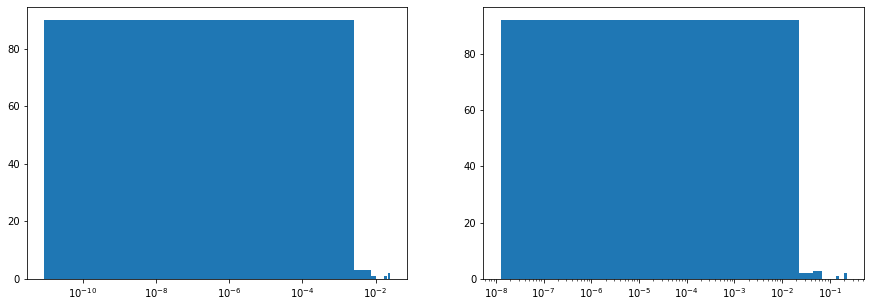

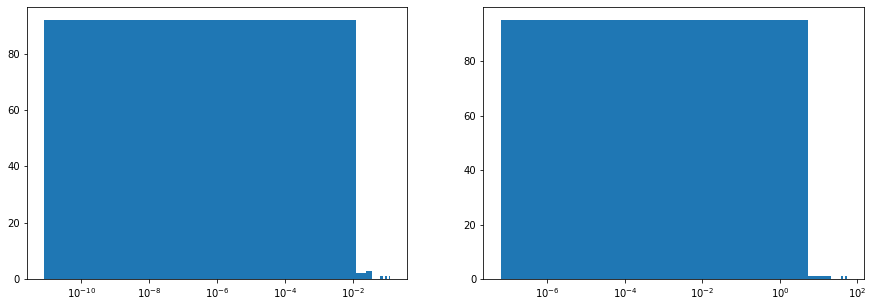

In [128]:
Mlzs = np.logspace(0, 5, 10)
ys = np.logspace(-2, np.log10(5), 10)
input_prms = np.array(list(product(Mlzs, ys)))
fs = np.arange(0.25, 1024, 1/4)
max_abs_err_abs_arr = np.array([None]*len(input_prms))
max_abs_err_phase_arr = np.array([None]*len(input_prms))
max_rel_err_abs_arr = np.array([None]*len(input_prms))
max_rel_err_phase_arr = np.array([None]*len(input_prms))

i=0
delta_y=1e-5
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(y)
    
    wfs = wfs_full[wfs_full<wc]
    if len(wfs) == 0:
        wfs=wfs_full[:5]
        
    Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
    
    y=y*(1+delta_y)
    Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
    
    max_abs_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert)))
    max_abs_err_phase = np.max(np.abs(np.angle(Ffs_cy) - np.angle(Ffs_cy_pert)))
    
    max_rel_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert))/np.abs(Ffs_cy))
    max_rel_err_phase = np.max(np.abs((np.angle(Ffs_cy) - np.angle(Ffs_cy_pert))/np.angle(Ffs_cy)))
    
    max_abs_err_abs_arr[i] = max_abs_err_abs
    max_abs_err_phase_arr[i] = max_abs_err_phase
    max_rel_err_abs_arr[i] = max_rel_err_abs
    max_rel_err_phase_arr[i] = max_rel_err_phase
    i+=1


fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(max_abs_err_abs_arr)
ax[1].hist(max_abs_err_phase_arr)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
plt.show()   
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(max_rel_err_abs_arr)
ax[1].hist(max_rel_err_phase_arr)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
plt.show()   

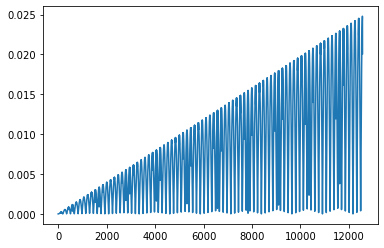

In [132]:
Mlz, y = input_prms[np.argmax(max_abs_err_abs_arr)]

wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
wc = pnt_lens_cy.wc_geo_re1p0(y)

wfs = wfs_full[wfs_full<wc]
if len(wfs) == 0:
    wfs=wfs_full[:5]

Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])

y=y*(1+delta_y)
Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])

plt.plot(wfs, np.abs(np.abs(Ffs_cy)-np.abs(Ffs_cy_pert)))

### Checking in different y ranges: 
### We will check the desired $\Delta y$ that works in each region then try to match different $\Delta y$ of each region with a single logspace array.

#### (i) $y\in(0.01,~0.05)$ 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.48it/s]


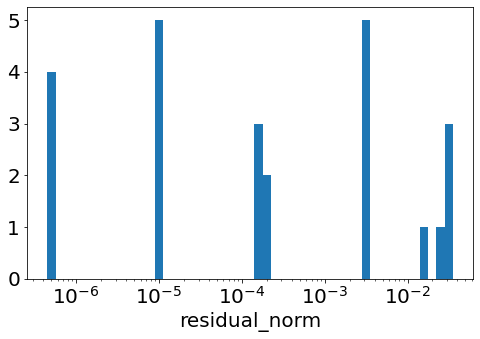

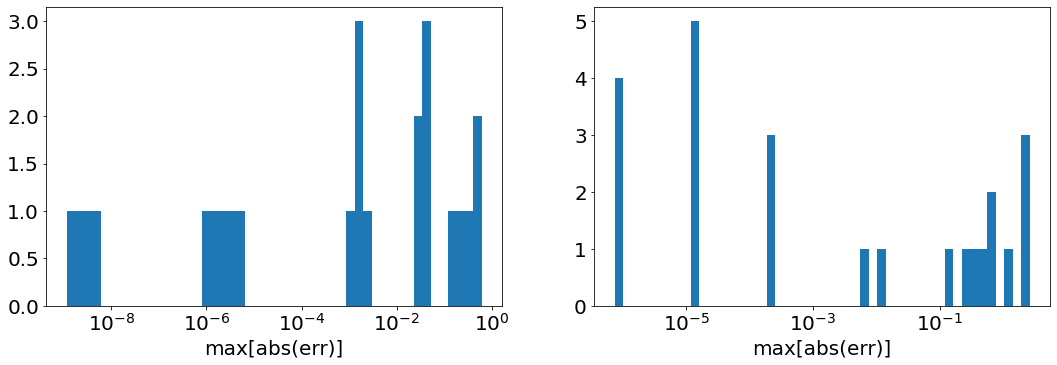

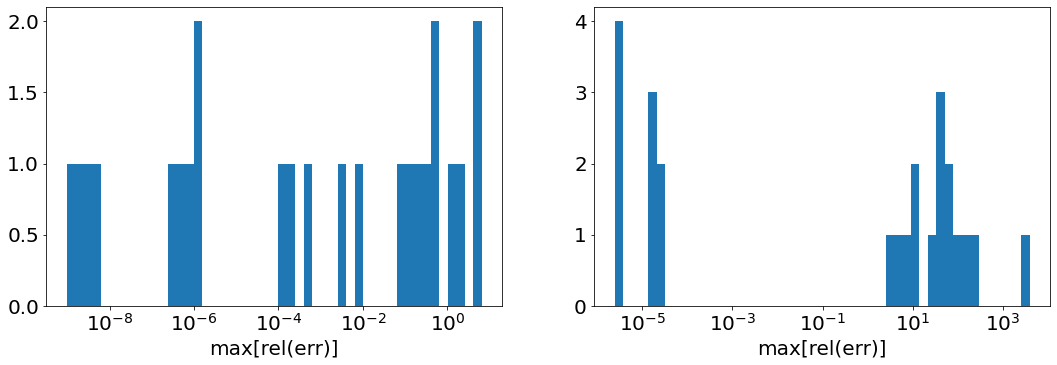

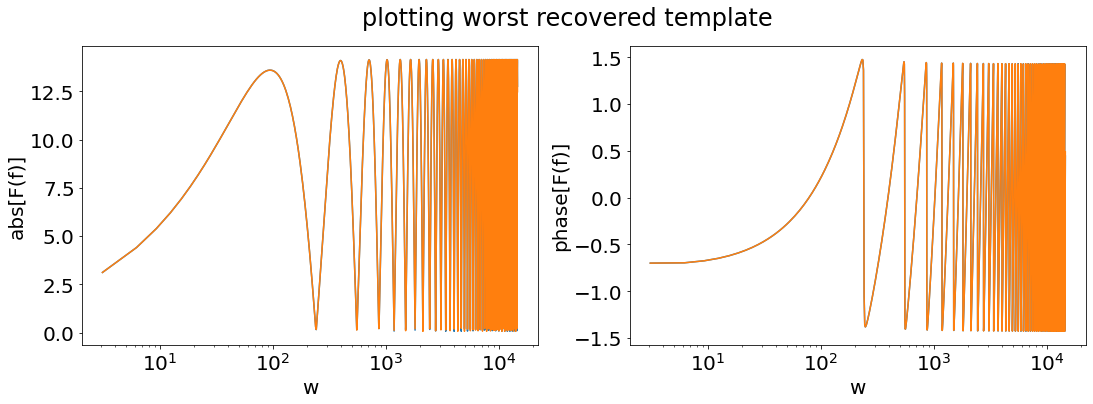

In [438]:
Mlzs = np.logspace(0, 5, 5)
ys = np.logspace(-2, np.log10(0.05), 5)

input_prms = np.array(list(product(Mlzs, ys)))
fs = np.arange(0.25, 2048, 1/4)
max_abs_err_abs_arr = np.array([None]*len(input_prms))
max_abs_err_phase_arr = np.array([None]*len(input_prms))
max_rel_err_abs_arr = np.array([None]*len(input_prms))
max_rel_err_phase_arr = np.array([None]*len(input_prms))

residuals = np.array([None]*len(input_prms))

delta_y=3e-6
i=0
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(y)
    
    wfs = wfs_full[wfs_full<wc]
    
    if len(wfs) == 0:
        residuals[i] = 1e-15
        max_abs_err_abs_arr[i] = 1e-15
        max_abs_err_phase_arr[i] = 1e-15
        max_rel_err_abs_arr[i] = 1e-15
        max_rel_err_phase_arr[i] = 1e-15
    else:    
        Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])

        y=y+delta_y
        Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
        
        residuals[i] = np.linalg.norm(Ffs_cy/np.linalg.norm(Ffs_cy) - Ffs_cy_pert/np.linalg.norm(Ffs_cy_pert) )
        
        max_abs_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert)))
        max_abs_err_phase = np.max(np.abs(np.angle(Ffs_cy) - np.angle(Ffs_cy_pert)))

        max_rel_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert))/np.abs(Ffs_cy))
        max_rel_err_phase = np.max(np.abs((np.angle(Ffs_cy) - np.angle(Ffs_cy_pert))/np.angle(Ffs_cy)))

        max_abs_err_abs_arr[i] = max_abs_err_abs
        max_abs_err_phase_arr[i] = max_abs_err_phase
        max_rel_err_abs_arr[i] = max_rel_err_abs
        max_rel_err_phase_arr[i] = max_rel_err_phase
    i+=1   

 
data = np.dstack((residuals, max_abs_err_abs_arr, max_abs_err_phase_arr, max_rel_err_abs_arr, max_rel_err_phase_arr))[0]
df = pd.DataFrame(data, columns=['residuals', 'max_abs_err_abs', 'max_abs_err_phase', 'max_rel_err_abs', 'max_rel_err_phase'])
df.to_csv('../data/error_analysis_y0p01-y0p05.dat', index=None, sep=' ')

# plotting residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=np.logspace(np.log10(np.min(residuals)), np.log10(np.max(residuals))))
plt.xlabel('residual_norm')
plt.xscale('log')
plt.show()  

#plotting maximum absolute errors
fig, ax = plt.subplots(1, 2, figsize=(18,5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_abs_err_abs_arr, bins=np.logspace(np.log10(np.min(max_abs_err_abs_arr)), np.log10(np.max(max_abs_err_abs_arr)) ))
ax[1].hist(max_abs_err_phase_arr, bins=np.logspace(np.log10(np.min(max_abs_err_phase_arr)), np.log10(np.max(max_abs_err_phase_arr))) )
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[abs(err)]')
plt.show()  

#plotting maximum relative errors
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_rel_err_abs_arr, bins=np.logspace(np.log10(np.min(max_rel_err_abs_arr)), np.log10(np.max(max_rel_err_abs_arr))))
ax[1].hist(max_rel_err_phase_arr, bins=np.logspace(np.log10(np.min(max_rel_err_phase_arr)), np.log10(np.max(max_rel_err_phase_arr))))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[rel(err)]')
plt.show()

# plot of WFs where residual was maximum
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ind = np.argmax(residuals)
Mlz, y = input_prms[ind]
wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
wc = pnt_lens_cy.wc_geo_re1p0(y)
wfs = wfs_full[wfs_full<wc]
if len(wfs) == 0:
    wfs=wfs_full[:5]
Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
y=y+delta_y
Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
fig.suptitle('plotting worst recovered template')
ax[0].plot(wfs, np.abs(Ffs_cy))
ax[0].plot(wfs, np.abs(Ffs_cy_pert))
ax[0].set_ylabel('abs[F(f)]')
ax[1].plot(wfs, np.angle(Ffs_cy))
ax[1].plot(wfs, np.angle(Ffs_cy_pert))
ax[1].set_ylabel('phase[F(f)]')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('w')
    tmp_ax.set_xscale('log')
plt.show()

#### (ii) $y\in(0.05,~0.08)$ 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.68it/s]


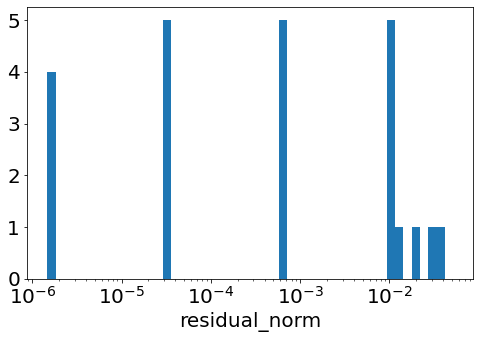

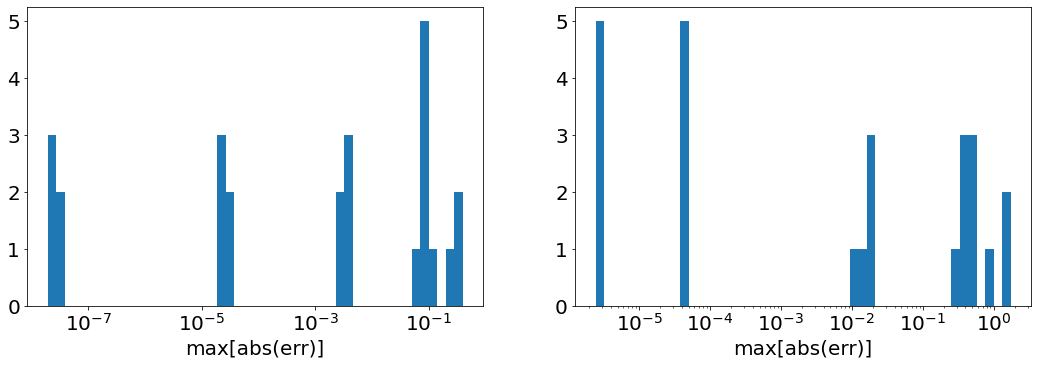

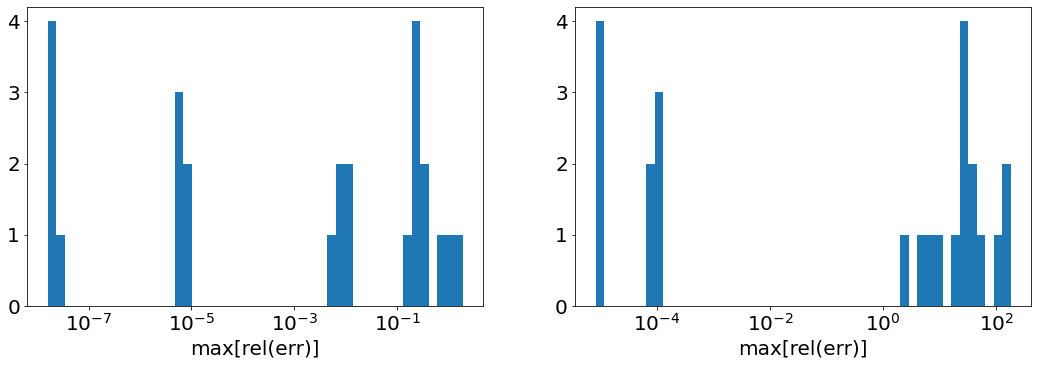

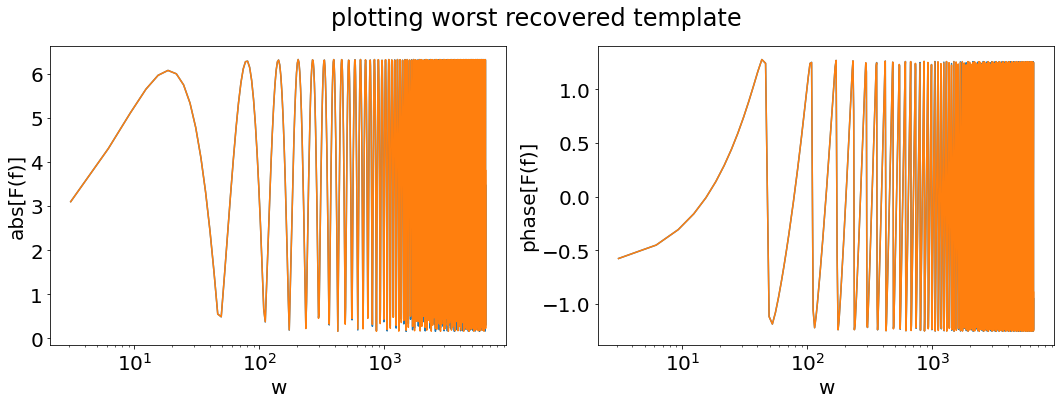

In [376]:
Mlzs = np.logspace(0, 5, 5)
ys = np.logspace(np.log10(0.05), np.log10(0.08), 5)

input_prms = np.array(list(product(Mlzs, ys)))
fs = np.arange(0.25, 2048, 1/4)
max_abs_err_abs_arr = np.array([None]*len(input_prms))
max_abs_err_phase_arr = np.array([None]*len(input_prms))
max_rel_err_abs_arr = np.array([None]*len(input_prms))
max_rel_err_phase_arr = np.array([None]*len(input_prms))

residuals = np.array([None]*len(input_prms))

delta_y=1e-5
i=0
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(y)
    
    wfs = wfs_full[wfs_full<wc]
    
    if len(wfs) == 0:
        residuals[i] = 1e-15
        max_abs_err_abs_arr[i] = 1e-15
        max_abs_err_phase_arr[i] = 1e-15
        max_rel_err_abs_arr[i] = 1e-15
        max_rel_err_phase_arr[i] = 1e-15
    else:    
        Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])

        y=y+delta_y
        Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
        
        residuals[i] = np.linalg.norm(Ffs_cy/np.linalg.norm(Ffs_cy) - Ffs_cy_pert/np.linalg.norm(Ffs_cy_pert) )
        
        max_abs_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert)))
        max_abs_err_phase = np.max(np.abs(np.angle(Ffs_cy) - np.angle(Ffs_cy_pert)))

        max_rel_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert))/np.abs(Ffs_cy))
        max_rel_err_phase = np.max(np.abs((np.angle(Ffs_cy) - np.angle(Ffs_cy_pert))/np.angle(Ffs_cy)))

        max_abs_err_abs_arr[i] = max_abs_err_abs
        max_abs_err_phase_arr[i] = max_abs_err_phase
        max_rel_err_abs_arr[i] = max_rel_err_abs
        max_rel_err_phase_arr[i] = max_rel_err_phase
    i+=1   

 
data = np.dstack((residuals, max_abs_err_abs_arr, max_abs_err_phase_arr, max_rel_err_abs_arr, max_rel_err_phase_arr))[0]
df = pd.DataFrame(data, columns=['residuals', 'max_abs_err_abs', 'max_abs_err_phase', 'max_rel_err_abs', 'max_rel_err_phase'])
df.to_csv('../data/error_analysis_y0p05-y0p08.dat', index=None, sep=' ')

# plotting residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=np.logspace(np.log10(np.min(residuals)), np.log10(np.max(residuals))))
plt.xlabel('residual_norm')
plt.xscale('log')
plt.show()  

#plotting maximum absolute errors
fig, ax = plt.subplots(1, 2, figsize=(18,5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_abs_err_abs_arr, bins=np.logspace(np.log10(np.min(max_abs_err_abs_arr)), np.log10(np.max(max_abs_err_abs_arr)) ))
ax[1].hist(max_abs_err_phase_arr, bins=np.logspace(np.log10(np.min(max_abs_err_phase_arr)), np.log10(np.max(max_abs_err_phase_arr))) )
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[abs(err)]')
plt.show()  

#plotting maximum relative errors
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_rel_err_abs_arr, bins=np.logspace(np.log10(np.min(max_rel_err_abs_arr)), np.log10(np.max(max_rel_err_abs_arr))))
ax[1].hist(max_rel_err_phase_arr, bins=np.logspace(np.log10(np.min(max_rel_err_phase_arr)), np.log10(np.max(max_rel_err_phase_arr))))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[rel(err)]')
plt.show()

# plot of WFs where residual was maximum
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ind = np.argmax(residuals)
Mlz, y = input_prms[ind]
wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
wc = pnt_lens_cy.wc_geo_re1p0(y)
wfs = wfs_full[wfs_full<wc]
if len(wfs) == 0:
    wfs=wfs_full[:5]
Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
y=y+delta_y
Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
fig.suptitle('plotting worst recovered template')
ax[0].plot(wfs, np.abs(Ffs_cy))
ax[0].plot(wfs, np.abs(Ffs_cy_pert))
ax[0].set_ylabel('abs[F(f)]')
ax[1].plot(wfs, np.angle(Ffs_cy))
ax[1].plot(wfs, np.angle(Ffs_cy_pert))
ax[1].set_ylabel('phase[F(f)]')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('w')
    tmp_ax.set_xscale('log')
plt.show()

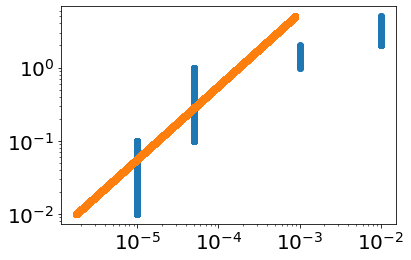

In [ ]:
ys_regs = [np.arange(1e-2, 1e-1, 1e-5), np.arange(1e-1, 1e-0, 5e-5), np.arange(1e0, 2e0, 1e-3),\
      np.arange(2e0, 5e0+1e-2, 1e-2)]
ys = np.concatenate(ys_regs)
ys2 = np.logspace(-2, np.log10(5), 35000)
len(ys), len(ys2)

dys = [ ys[i+1] - ys[i] for i in range(len(ys) -1 )]
dys2 = [ ys2[i+1] - ys2[i] for i in range(len(ys2) -1 )]

# plt.scatter(ys[:-1], dys)
# plt.scatter(ys2[:-1], dys2)
plt.scatter(dys, ys[:-1])
plt.scatter(dys2, ys2[:-1])
plt.yscale('log')
plt.xscale('log')

In [ ]:
dys2[11000]

1.2521853581623499e-05

(8e-06, 2e-05)

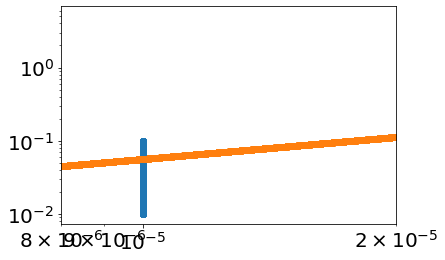

In [400]:
# plt.scatter(ys[:-1], dys)
# plt.scatter(ys2[:-1], dys2)
plt.scatter(dys, ys[:-1])
plt.scatter(dys2, ys2[:-1])
plt.yscale('log')
plt.xscale('log')
plt.xlim(8e-6, 2e-5)

#### (iii) $y\in(0.08,~0.10)$ 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.69it/s]


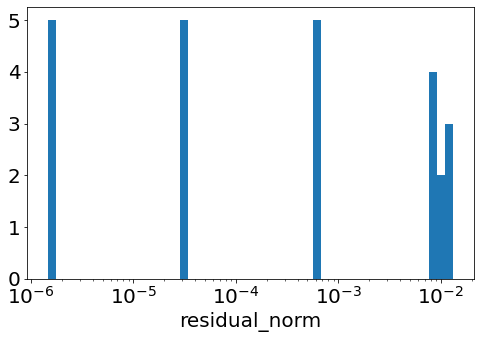

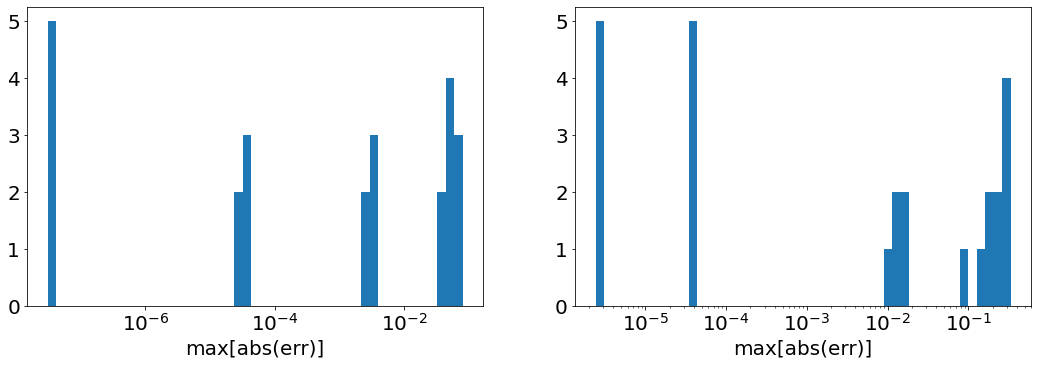

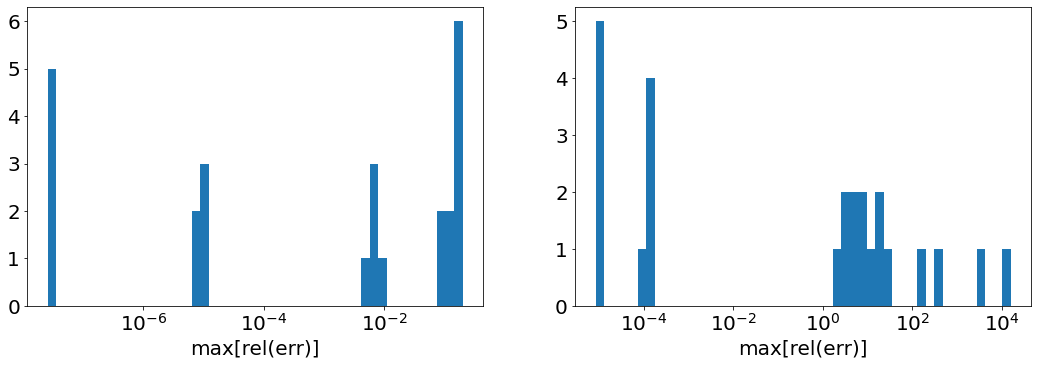

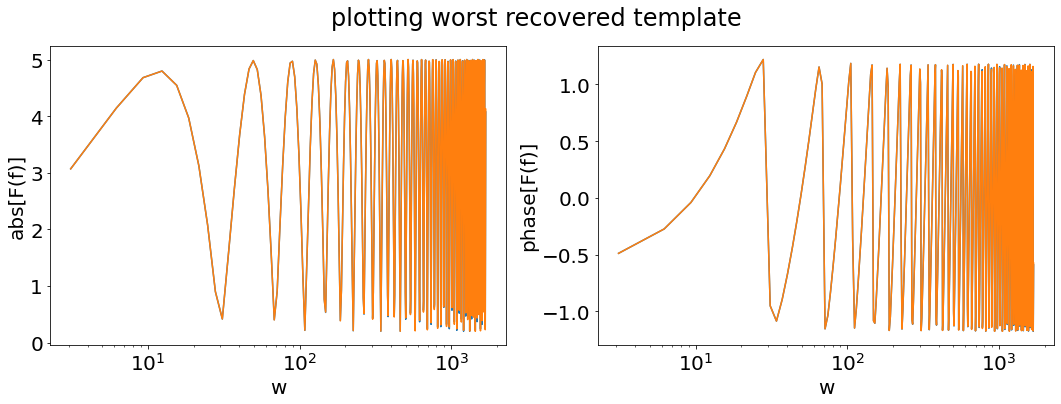

In [381]:
Mlzs = np.logspace(0, 5, 5)
ys = np.logspace(np.log10(0.08), np.log10(0.10), 5)

input_prms = np.array(list(product(Mlzs, ys)))
fs = np.arange(0.25, 2048, 1/4)
max_abs_err_abs_arr = np.array([None]*len(input_prms))
max_abs_err_phase_arr = np.array([None]*len(input_prms))
max_rel_err_abs_arr = np.array([None]*len(input_prms))
max_rel_err_phase_arr = np.array([None]*len(input_prms))

residuals = np.array([None]*len(input_prms))

delta_y=1e-5
i=0
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(y)
    
    wfs = wfs_full[wfs_full<wc]
    
    if len(wfs) == 0:
        residuals[i] = 1e-15
        max_abs_err_abs_arr[i] = 1e-15
        max_abs_err_phase_arr[i] = 1e-15
        max_rel_err_abs_arr[i] = 1e-15
        max_rel_err_phase_arr[i] = 1e-15
    else:    
        Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])

        y=y+delta_y
        Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
        
        residuals[i] = np.linalg.norm(Ffs_cy/np.linalg.norm(Ffs_cy) - Ffs_cy_pert/np.linalg.norm(Ffs_cy_pert) )
        
        max_abs_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert)))
        max_abs_err_phase = np.max(np.abs(np.angle(Ffs_cy) - np.angle(Ffs_cy_pert)))

        max_rel_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert))/np.abs(Ffs_cy))
        max_rel_err_phase = np.max(np.abs((np.angle(Ffs_cy) - np.angle(Ffs_cy_pert))/np.angle(Ffs_cy)))

        max_abs_err_abs_arr[i] = max_abs_err_abs
        max_abs_err_phase_arr[i] = max_abs_err_phase
        max_rel_err_abs_arr[i] = max_rel_err_abs
        max_rel_err_phase_arr[i] = max_rel_err_phase
    i+=1   

 
data = np.dstack((residuals, max_abs_err_abs_arr, max_abs_err_phase_arr, max_rel_err_abs_arr, max_rel_err_phase_arr))[0]
df = pd.DataFrame(data, columns=['residuals', 'max_abs_err_abs', 'max_abs_err_phase', 'max_rel_err_abs', 'max_rel_err_phase'])
df.to_csv('../data/error_analysis_y0p05-y0p08.dat', index=None, sep=' ')

# plotting residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=np.logspace(np.log10(np.min(residuals)), np.log10(np.max(residuals))))
plt.xlabel('residual_norm')
plt.xscale('log')
plt.show()  

#plotting maximum absolute errors
fig, ax = plt.subplots(1, 2, figsize=(18,5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_abs_err_abs_arr, bins=np.logspace(np.log10(np.min(max_abs_err_abs_arr)), np.log10(np.max(max_abs_err_abs_arr)) ))
ax[1].hist(max_abs_err_phase_arr, bins=np.logspace(np.log10(np.min(max_abs_err_phase_arr)), np.log10(np.max(max_abs_err_phase_arr))) )
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[abs(err)]')
plt.show()  

#plotting maximum relative errors
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_rel_err_abs_arr, bins=np.logspace(np.log10(np.min(max_rel_err_abs_arr)), np.log10(np.max(max_rel_err_abs_arr))))
ax[1].hist(max_rel_err_phase_arr, bins=np.logspace(np.log10(np.min(max_rel_err_phase_arr)), np.log10(np.max(max_rel_err_phase_arr))))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[rel(err)]')
plt.show()

# plot of WFs where residual was maximum
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ind = np.argmax(residuals)
Mlz, y = input_prms[ind]
wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
wc = pnt_lens_cy.wc_geo_re1p0(y)
wfs = wfs_full[wfs_full<wc]
if len(wfs) == 0:
    wfs=wfs_full[:5]
Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
y=y+delta_y
Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
fig.suptitle('plotting worst recovered template')
ax[0].plot(wfs, np.abs(Ffs_cy))
ax[0].plot(wfs, np.abs(Ffs_cy_pert))
ax[0].set_ylabel('abs[F(f)]')
ax[1].plot(wfs, np.angle(Ffs_cy))
ax[1].plot(wfs, np.angle(Ffs_cy_pert))
ax[1].set_ylabel('phase[F(f)]')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('w')
    tmp_ax.set_xscale('log')
plt.show()

#### (iv) $y\in(0.1,~0.5)$ 

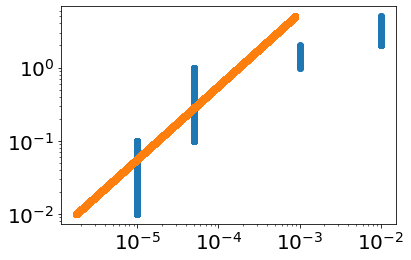

In [386]:
ys_regs = [np.arange(1e-2, 1e-1, 1e-5), np.arange(1e-1, 1e-0, 5e-5), np.arange(1e0, 2e0, 1e-3),\
      np.arange(2e0, 5e0+1e-2, 1e-2)]
ys = np.concatenate(ys_regs)
ys2 = np.logspace(-2, np.log10(5), 35000)
len(ys), len(ys2)

dys = [ ys[i+1] - ys[i] for i in range(len(ys) -1 )]
dys2 = [ ys2[i+1] - ys2[i] for i in range(len(ys2) -1 )]

# plt.scatter(ys[:-1], dys)
# plt.scatter(ys2[:-1], dys2)
plt.scatter(dys, ys[:-1])
plt.scatter(dys2, ys2[:-1])
plt.yscale('log')
plt.xscale('log')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


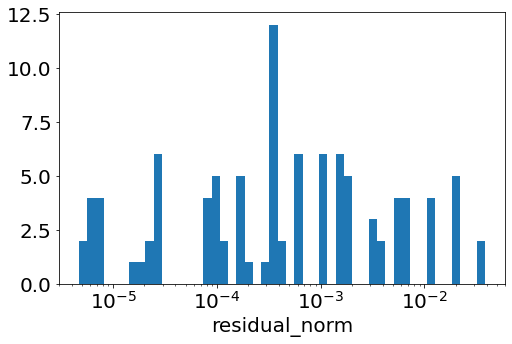

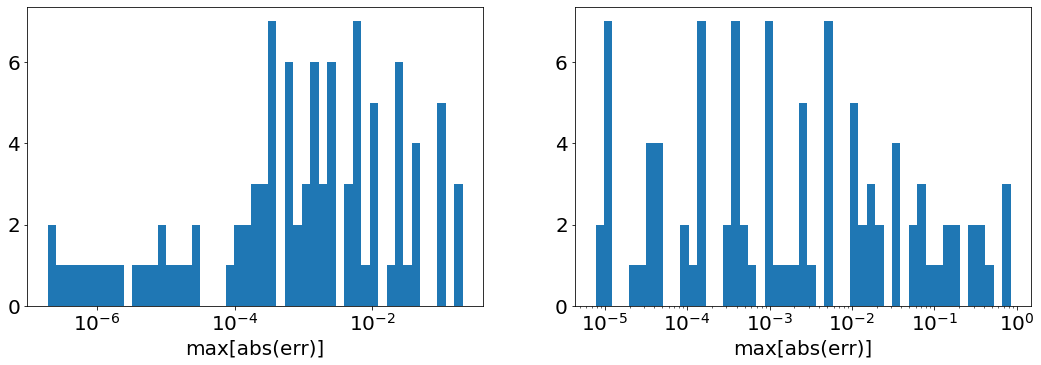

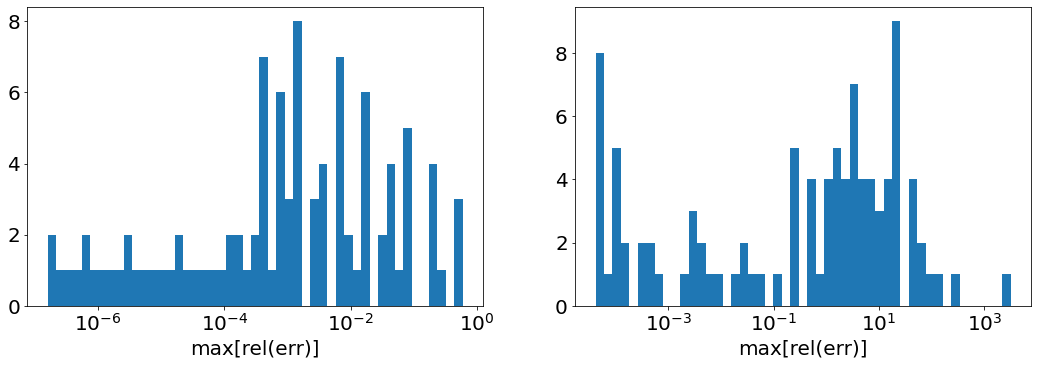

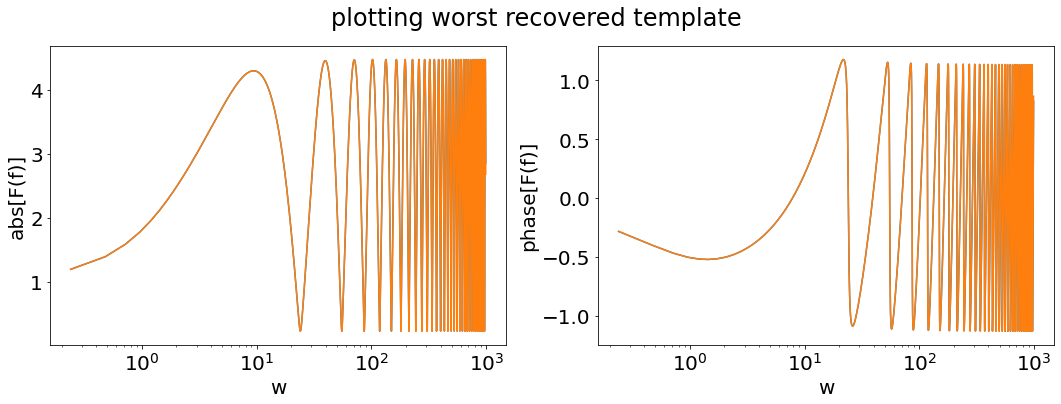

In [330]:
Mlzs = np.logspace(0, 5, 5)
ys = np.logspace(-1, 0.5, 5)

input_prms = np.array(list(product(Mlzs, ys)))
fs = np.arange(0.25, 2048, 1/4)
max_abs_err_abs_arr = np.array([None]*len(input_prms))
max_abs_err_phase_arr = np.array([None]*len(input_prms))
max_rel_err_abs_arr = np.array([None]*len(input_prms))
max_rel_err_phase_arr = np.array([None]*len(input_prms))

residuals = np.array([None]*len(input_prms))

delta_y=5e-5
i=0
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(y)
    
    wfs = wfs_full[wfs_full<wc]
    
    if len(wfs) == 0:
        residuals[i] = 1e-15
        max_abs_err_abs_arr[i] = 1e-15
        max_abs_err_phase_arr[i] = 1e-15
        max_rel_err_abs_arr[i] = 1e-15
        max_rel_err_phase_arr[i] = 1e-15
    else:    
        Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])

        y=y+delta_y
        Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
        
        residuals[i] = np.linalg.norm(Ffs_cy/np.linalg.norm(Ffs_cy) - Ffs_cy_pert/np.linalg.norm(Ffs_cy_pert) )
        
        max_abs_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert)))
        max_abs_err_phase = np.max(np.abs(np.angle(Ffs_cy) - np.angle(Ffs_cy_pert)))

        max_rel_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert))/np.abs(Ffs_cy))
        max_rel_err_phase = np.max(np.abs((np.angle(Ffs_cy) - np.angle(Ffs_cy_pert))/np.angle(Ffs_cy)))

        max_abs_err_abs_arr[i] = max_abs_err_abs
        max_abs_err_phase_arr[i] = max_abs_err_phase
        max_rel_err_abs_arr[i] = max_rel_err_abs
        max_rel_err_phase_arr[i] = max_rel_err_phase
    i+=1   

 
data = np.dstack((residuals, max_abs_err_abs_arr, max_abs_err_phase_arr, max_rel_err_abs_arr, max_rel_err_phase_arr))[0]
df = pd.DataFrame(data, columns=['residuals', 'max_abs_err_abs', 'max_abs_err_phase', 'max_rel_err_abs', 'max_rel_err_phase'])
df.to_csv('../data/error_analysis_y0p1-y1p0.dat', index=None, sep=' ')

# plotting residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=np.logspace(np.log10(np.min(residuals)), np.log10(np.max(residuals))))
plt.xlabel('residual_norm')
plt.xscale('log')
plt.show()  

#plotting maximum absolute errors
fig, ax = plt.subplots(1, 2, figsize=(18,5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_abs_err_abs_arr, bins=np.logspace(np.log10(np.min(max_abs_err_abs_arr)), np.log10(np.max(max_abs_err_abs_arr)) ))
ax[1].hist(max_abs_err_phase_arr, bins=np.logspace(np.log10(np.min(max_abs_err_phase_arr)), np.log10(np.max(max_abs_err_phase_arr))) )
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[abs(err)]')
plt.show()  

#plotting maximum relative errors
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_rel_err_abs_arr, bins=np.logspace(np.log10(np.min(max_rel_err_abs_arr)), np.log10(np.max(max_rel_err_abs_arr))))
ax[1].hist(max_rel_err_phase_arr, bins=np.logspace(np.log10(np.min(max_rel_err_phase_arr)), np.log10(np.max(max_rel_err_phase_arr))))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[rel(err)]')
plt.show()

# plot of WFs where residual was maximum
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ind = np.argmax(residuals)
Mlz, y = input_prms[ind]
wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
wc = pnt_lens_cy.wc_geo_re1p0(y)
wfs = wfs_full[wfs_full<wc]
if len(wfs) == 0:
    wfs=wfs_full[:5]
Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
y=y+delta_y
Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
fig.suptitle('plotting worst recovered template')
ax[0].plot(wfs, np.abs(Ffs_cy))
ax[0].plot(wfs, np.abs(Ffs_cy_pert))
ax[0].set_ylabel('abs[F(f)]')
ax[1].plot(wfs, np.angle(Ffs_cy))
ax[1].plot(wfs, np.angle(Ffs_cy_pert))
ax[1].set_ylabel('phase[F(f)]')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('w')
    tmp_ax.set_xscale('log')
plt.show()

#### (iii) $y\in(1.0,~2.0)$ 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


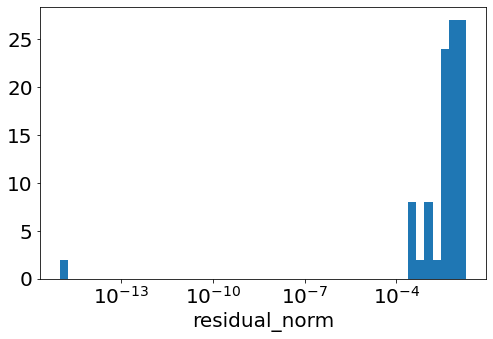

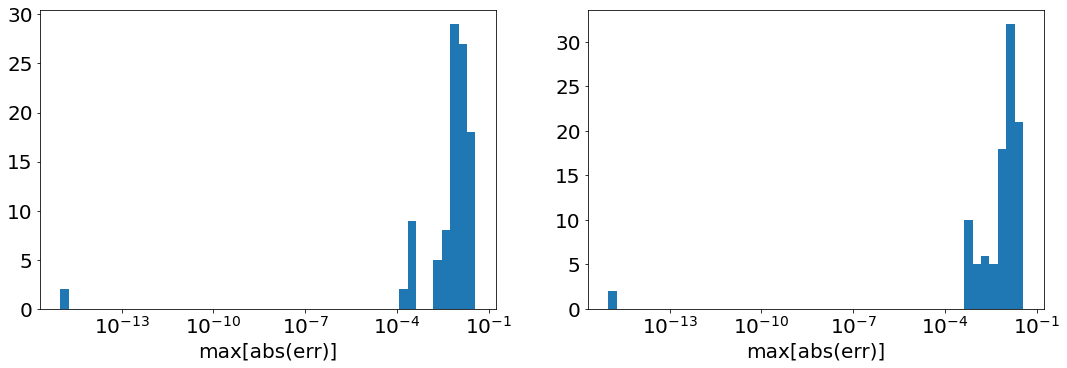

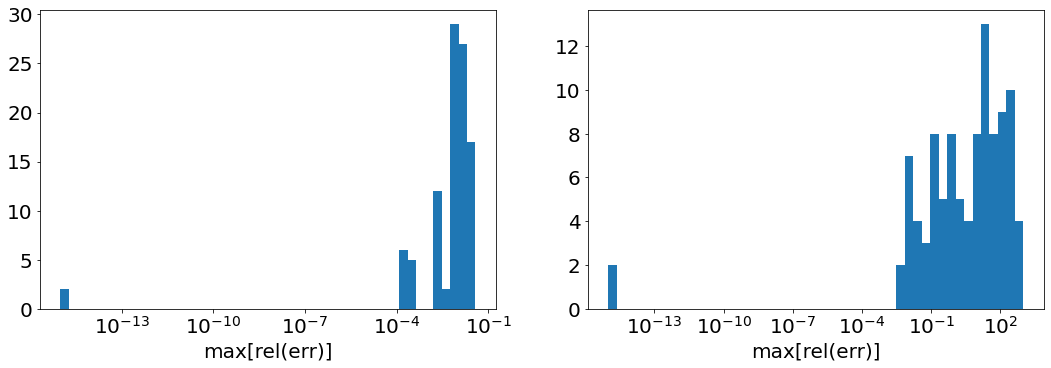

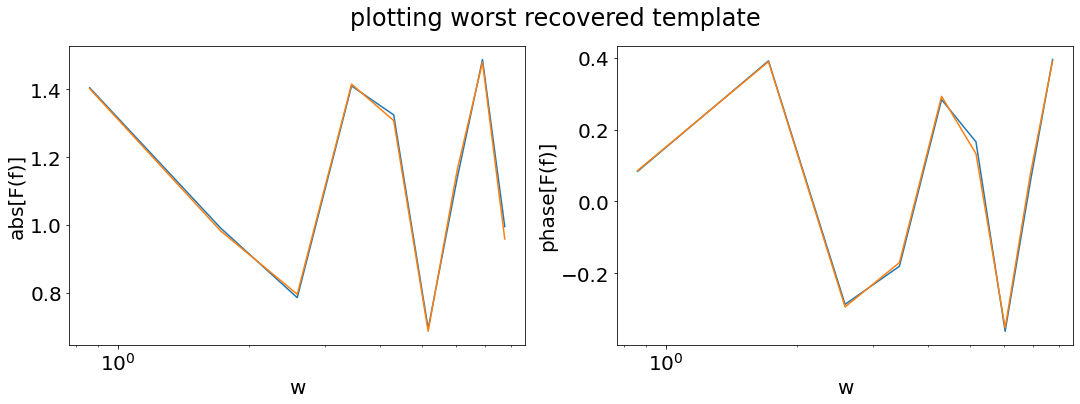

In [331]:
Mlzs = np.logspace(0, 5, 10)
ys = np.logspace(0, np.log10(2-1e-2), 10)

input_prms = np.array(list(product(Mlzs, ys)))
fs = np.arange(0.25, 2048, 1/4)
max_abs_err_abs_arr = np.array([None]*len(input_prms))
max_abs_err_phase_arr = np.array([None]*len(input_prms))
max_rel_err_abs_arr = np.array([None]*len(input_prms))
max_rel_err_phase_arr = np.array([None]*len(input_prms))

residuals = np.array([None]*len(input_prms))

delta_y=5e-3
i=0
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(y)
    
    wfs = wfs_full[wfs_full<wc]
    
    if len(wfs) == 0:
        residuals[i] = 1e-15
        max_abs_err_abs_arr[i] = 1e-15
        max_abs_err_phase_arr[i] = 1e-15
        max_rel_err_abs_arr[i] = 1e-15
        max_rel_err_phase_arr[i] = 1e-15
    else:    
        Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])

        y=y+delta_y
        Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
        
        residuals[i] = np.linalg.norm(Ffs_cy/np.linalg.norm(Ffs_cy) - Ffs_cy_pert/np.linalg.norm(Ffs_cy_pert) )
        
        max_abs_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert)))
        max_abs_err_phase = np.max(np.abs(np.angle(Ffs_cy) - np.angle(Ffs_cy_pert)))

        max_rel_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert))/np.abs(Ffs_cy))
        max_rel_err_phase = np.max(np.abs((np.angle(Ffs_cy) - np.angle(Ffs_cy_pert))/np.angle(Ffs_cy)))

        max_abs_err_abs_arr[i] = max_abs_err_abs
        max_abs_err_phase_arr[i] = max_abs_err_phase
        max_rel_err_abs_arr[i] = max_rel_err_abs
        max_rel_err_phase_arr[i] = max_rel_err_phase
    i+=1   

 
data = np.dstack((residuals, max_abs_err_abs_arr, max_abs_err_phase_arr, max_rel_err_abs_arr, max_rel_err_phase_arr))[0]
df = pd.DataFrame(data, columns=['residuals', 'max_abs_err_abs', 'max_abs_err_phase', 'max_rel_err_abs', 'max_rel_err_phase'])
df.to_csv('../data/error_analysis_y1p0-y2p0.dat', index=None, sep=' ')

# plotting residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=np.logspace(np.log10(np.min(residuals)), np.log10(np.max(residuals))))
plt.xlabel('residual_norm')
plt.xscale('log')
plt.show()  

#plotting maximum absolute errors
fig, ax = plt.subplots(1, 2, figsize=(18,5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_abs_err_abs_arr, bins=np.logspace(np.log10(np.min(max_abs_err_abs_arr)), np.log10(np.max(max_abs_err_abs_arr)) ))
ax[1].hist(max_abs_err_phase_arr, bins=np.logspace(np.log10(np.min(max_abs_err_phase_arr)), np.log10(np.max(max_abs_err_phase_arr))) )
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[abs(err)]')
plt.show()  

#plotting maximum relative errors
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_rel_err_abs_arr, bins=np.logspace(np.log10(np.min(max_rel_err_abs_arr)), np.log10(np.max(max_rel_err_abs_arr))))
ax[1].hist(max_rel_err_phase_arr, bins=np.logspace(np.log10(np.min(max_rel_err_phase_arr)), np.log10(np.max(max_rel_err_phase_arr))))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[rel(err)]')
plt.show()

# plot of WFs where residual was maximum
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ind = np.argmax(residuals)
Mlz, y = input_prms[ind]
wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
wc = pnt_lens_cy.wc_geo_re1p0(y)
wfs = wfs_full[wfs_full<wc]
if len(wfs) == 0:
    wfs=wfs_full[:5]
Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
y=y+delta_y
Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
fig.suptitle('plotting worst recovered template')
ax[0].plot(wfs, np.abs(Ffs_cy))
ax[0].plot(wfs, np.abs(Ffs_cy_pert))
ax[0].set_ylabel('abs[F(f)]')
ax[1].plot(wfs, np.angle(Ffs_cy))
ax[1].plot(wfs, np.angle(Ffs_cy_pert))
ax[1].set_ylabel('phase[F(f)]')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('w')
    tmp_ax.set_xscale('log')
plt.show()

#### (iii) $y\in(2.0,~5.0)$ 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


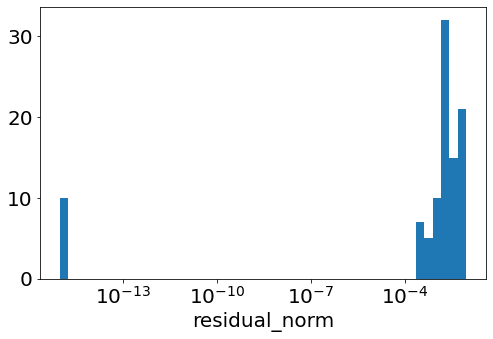

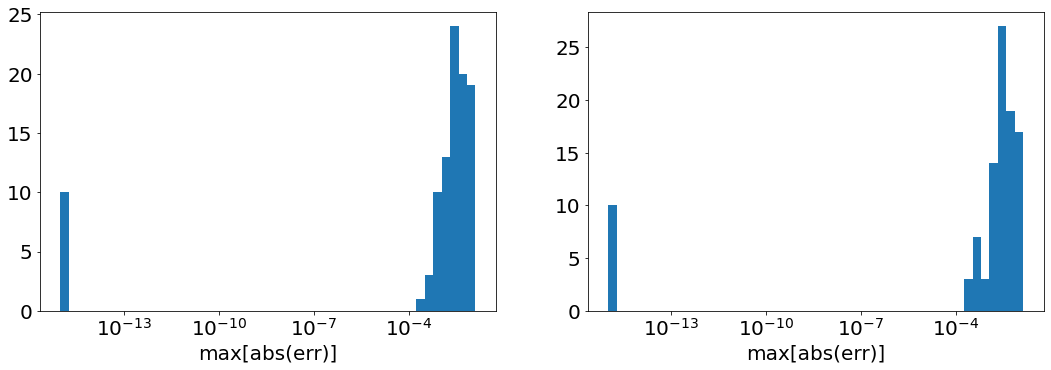

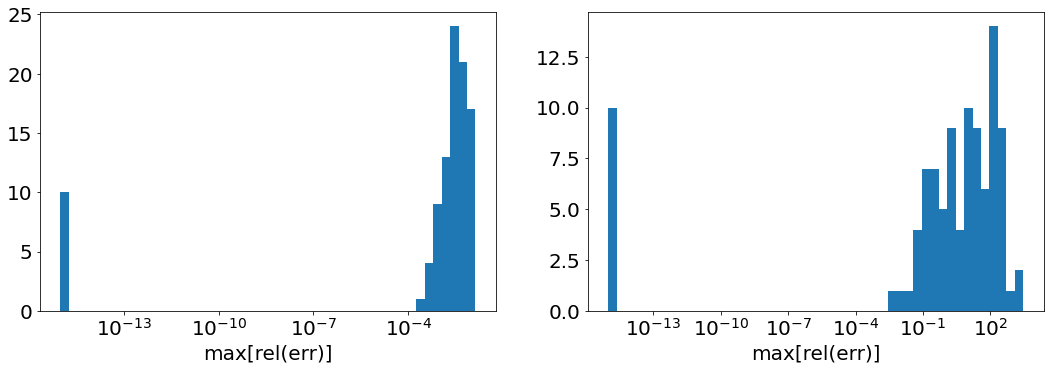

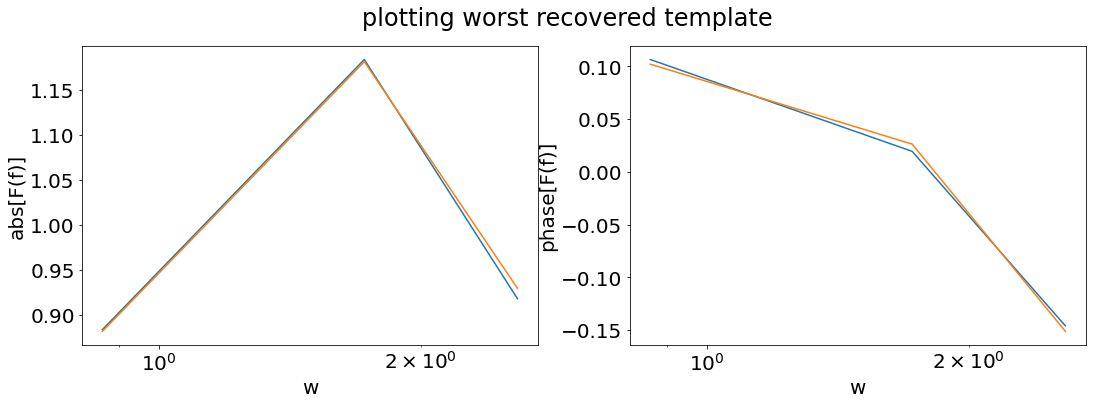

In [332]:
Mlzs = np.logspace(0, 5, 10)
ys = np.logspace(np.log10(2), np.log10(5-1e-1), 10)

input_prms = np.array(list(product(Mlzs, ys)))
fs = np.arange(0.25, 2048, 1/4)
max_abs_err_abs_arr = np.array([None]*len(input_prms))
max_abs_err_phase_arr = np.array([None]*len(input_prms))
max_rel_err_abs_arr = np.array([None]*len(input_prms))
max_rel_err_phase_arr = np.array([None]*len(input_prms))

residuals = np.array([None]*len(input_prms))

delta_y=1e-2
i=0
for inp in tqdm(input_prms):
    Mlz, y = inp
    wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
    wc = pnt_lens_cy.wc_geo_re1p0(y)
    
    wfs = wfs_full[wfs_full<wc]
    
    if len(wfs) == 0:
        residuals[i] = 1e-15
        max_abs_err_abs_arr[i] = 1e-15
        max_abs_err_phase_arr[i] = 1e-15
        max_rel_err_abs_arr[i] = 1e-15
        max_rel_err_phase_arr[i] = 1e-15
    else:    
        Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])

        y=y+delta_y
        Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
        
        residuals[i] = np.linalg.norm(Ffs_cy/np.linalg.norm(Ffs_cy) - Ffs_cy_pert/np.linalg.norm(Ffs_cy_pert) )
        
        max_abs_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert)))
        max_abs_err_phase = np.max(np.abs(np.angle(Ffs_cy) - np.angle(Ffs_cy_pert)))

        max_rel_err_abs = np.max(np.abs(np.abs(Ffs_cy) - np.abs(Ffs_cy_pert))/np.abs(Ffs_cy))
        max_rel_err_phase = np.max(np.abs((np.angle(Ffs_cy) - np.angle(Ffs_cy_pert))/np.angle(Ffs_cy)))

        max_abs_err_abs_arr[i] = max_abs_err_abs
        max_abs_err_phase_arr[i] = max_abs_err_phase
        max_rel_err_abs_arr[i] = max_rel_err_abs
        max_rel_err_phase_arr[i] = max_rel_err_phase
    i+=1   

 
data = np.dstack((residuals, max_abs_err_abs_arr, max_abs_err_phase_arr, max_rel_err_abs_arr, max_rel_err_phase_arr))[0]
df = pd.DataFrame(data, columns=['residuals', 'max_abs_err_abs', 'max_abs_err_phase', 'max_rel_err_abs', 'max_rel_err_phase'])
df.to_csv('../data/error_analysis_y2p0-y5p0.dat', index=None, sep=' ')

# plotting residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=np.logspace(np.log10(np.min(residuals)), np.log10(np.max(residuals))))
plt.xlabel('residual_norm')
plt.xscale('log')
plt.show()  

#plotting maximum absolute errors
fig, ax = plt.subplots(1, 2, figsize=(18,5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_abs_err_abs_arr, bins=np.logspace(np.log10(np.min(max_abs_err_abs_arr)), np.log10(np.max(max_abs_err_abs_arr)) ))
ax[1].hist(max_abs_err_phase_arr, bins=np.logspace(np.log10(np.min(max_abs_err_phase_arr)), np.log10(np.max(max_abs_err_phase_arr))) )
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[abs(err)]')
plt.show()  

#plotting maximum relative errors
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ax[0].hist(max_rel_err_abs_arr, bins=np.logspace(np.log10(np.min(max_rel_err_abs_arr)), np.log10(np.max(max_rel_err_abs_arr))))
ax[1].hist(max_rel_err_phase_arr, bins=np.logspace(np.log10(np.min(max_rel_err_phase_arr)), np.log10(np.max(max_rel_err_phase_arr))))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('max[rel(err)]')
plt.show()

# plot of WFs where residual was maximum
fig, ax = plt.subplots(1, 2, figsize=(18, 5.5))
plt.rcParams.update({'font.size':20})
ind = np.argmax(residuals)
Mlz, y = input_prms[ind]
wfs_full = np.array([pnt_lens_cy.w_of_f(f, ml=Mlz, zl=0) for f in fs])
wc = pnt_lens_cy.wc_geo_re1p0(y)
wfs = wfs_full[wfs_full<wc]
if len(wfs) == 0:
    wfs=wfs_full[:5]
Ffs_cy = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
y=y+delta_y
Ffs_cy_pert = np.array([pnt_lens_cy.point_Fw_eff(wf, y=y) for wf in wfs])
fig.suptitle('plotting worst recovered template')
ax[0].plot(wfs, np.abs(Ffs_cy))
ax[0].plot(wfs, np.abs(Ffs_cy_pert))
ax[0].set_ylabel('abs[F(f)]')
ax[1].plot(wfs, np.angle(Ffs_cy))
ax[1].plot(wfs, np.angle(Ffs_cy_pert))
ax[1].set_ylabel('phase[F(f)]')
for tmp_ax in ax.flatten():
    tmp_ax.set_xlabel('w')
    tmp_ax.set_xscale('log')
plt.show()

## 3. Grid Generation

28301 40000


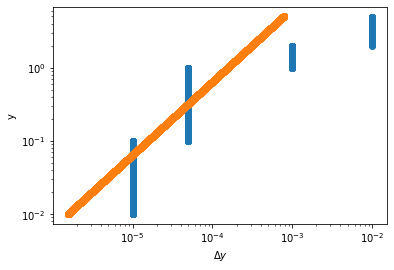

In [11]:
## fitting a logspace for y grid points 
ys_regs = [np.arange(1e-2, 1e-1, 1e-5), np.arange(1e-1, 1e-0, 5e-5), np.arange(1e0, 2e0, 1e-3),\
      np.arange(2e0, 5e0+1e-2, 1e-2)]
ys = np.concatenate(ys_regs)
ys2 = np.logspace(-2, np.log10(5), 40000)
print(len(ys), len(ys2))

dys = [ ys[i+1] - ys[i] for i in range(len(ys) -1 )]
dys2 = [ ys2[i+1] - ys2[i] for i in range(len(ys2) -1 )]

# plt.scatter(ys[:-1], dys)
# plt.scatter(ys2[:-1], dys2)
plt.scatter(dys, ys[:-1])
plt.scatter(dys2, ys2[:-1])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\Delta y$')
plt.ylabel('y')
plt.show()

7502 6000


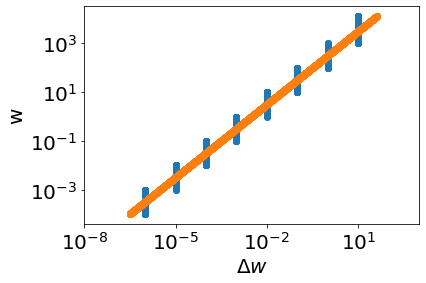

In [445]:
## fitting a logspace for w grid points 

# ws_regs = [np.arange(1e-4, 1e-3, 5e-6),
# np.arange(1e-3, 1e-2, 5e-5),
# np.arange(1e-2, 1e-1, 5e-4),
# np.arange(1e-1, 1e-0, 5e-3),
# np.arange(1e-0, 1e1, 5e-2),
# np.arange(1e1, 1e2, 5e-1),
# np.arange(1e2, 1e3, 5e0),
# np.arange(1e3, 1.3e4+5e1, 5e1)]
# ws = np.concatenate(ws_regs)

ws_regs = [np.arange(1e-4, 1e-3, 1e-6),
np.arange(1e-3, 1e-2, 1e-5),
np.arange(1e-2, 1e-1, 1e-4),
np.arange(1e-1, 1e-0, 1e-3),
np.arange(1e-0, 1e1, 1e-2),
np.arange(1e1, 1e2, 1e-1),
np.arange(1e2, 1e3, 1e0),
np.arange(1e3, 1.3e4+1e1, 1e1)]
ws = np.concatenate(ws_regs)

ws2 = np.logspace(-4, np.log10(1.3e4), 6000)

print(len(ws), len(ws2))

dws = [ ws[i+1] - ws[i] for i in range(len(ws) -1 )]
dws2 = [ ws2[i+1] - ws2[i] for i in range(len(ws2) -1 )]

# plt.scatter(ys[:-1], dys)
# plt.scatter(ys2[:-1], dys2)
plt.scatter(dws, ws[:-1])
plt.scatter(dws2, ws2[:-1])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\Delta w$')
plt.ylabel('w')
plt.xlim(1e-8, 1e3)
plt.show()

In [14]:
### Grid Generation ###
ys = np.logspace(-2, np.log10(5), 35000)
ws = np.logspace(-4, np.log10(1.3e4), 6000)

y_w_grid = []   #np.array([None]*len(input_prms))
for y in ys[:]:
    wc = pnt_lens_cy.wc_geo_re1p0(y)
    tmp_ws = ws[ws<=1.1*wc]
    y_w_grid.append([y, tmp_ws])
    
y_w_grid = np.array(y_w_grid, dtype=object)     

print('ys: ({:.3f}, {:.3f}), len(ys)={}'.format(ys[0], ys[-1], len(ys)))
print('ws: ({:.4f}, {:2f}), max_len(ws)={}'.format(ws[0], ws[-1], len(ws)))
print('Total points in grid: ', np.sum([len(y_w_grid[i][1]) for i in range(len(y_w_grid))]) )

ys: (0.010, 5.000), len(ys)=35000
ws: (0.0001, 13000.000000), max_len(ws)=6000
Total points in grid:  162308067


In [15]:
wc = pnt_lens_cy.wc_geo_re1p0(0.1)
tmp_ws = ws[ws<=1.1*wc]

In [16]:
len(tmp_ws)

5203

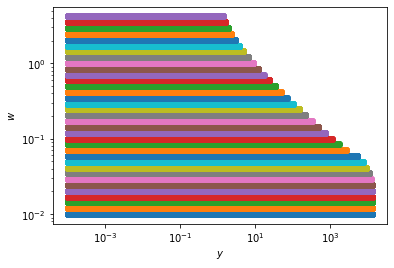

In [8]:
for grids in y_w_grid[::1000]:
    plt.scatter(grids[1], [grids[0]]*len(grids[1]))

plt.xscale('log') 
plt.yscale('log') 
plt.xlabel('$y$')
plt.ylabel('$w$')
plt.show()

## 4. Generating the lookup table

In [10]:
import pickle

outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0'

if __name__=='__main__': 
    npool = 5
    pool = mp.Pool(processes=npool)
    t1=time.time()
    Ff_grid = dict()
    k=0
    for y_ws in tqdm(y_w_grid):
        g_y = y_ws[0]
        g_ws = y_ws[1]
        Ff_eff_partial = partial(pnt_lens_py.point_Fw_eff, y = g_y)
        tmp_res = np.array(list(pool.map(Ff_eff_partial, g_ws)))
        Ff_grid[str(k)] = dict(y=g_y, ws=g_ws, Ffs_real=np.real(tmp_res), Ffs_imag=np.imag(tmp_res))    
        k+=1
    t2 = time.time() 
    print('\nComputation Time (generation) = {:.2f} s'.format(t2-t1))

t1 = time.time()
with open(outdir + label + '.pkl', 'wb') as f:
    pickle.dump(Ff_grid, f)
t2 = time.time() 
print('Computation Time (exporting) = {:.2f} s'.format(t2-t1))  

with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)

print('\nNumber of entries in lookup_table: ', len(Ff_grid))    

100%|██████████| 35000/35000 [3:09:40<00:00,  3.08it/s]  



Computation Time (generation) = 11380.72 s
Computation Time (exporting) = 8.16 s

Number of entries in lookup_table:  35000
